## Use Merlion for Anomaly Detection

### Reference:
- github: https://github.com/salesforce/Merlion

### Notes on installing Merlion:

- according to the github page,using `pip install salesforce-merlion` should be sufficient to have the Merlion package installed. 
- however, on Windows machine, an error can occur due to Merlion's dependency package `fbprophet`. 
- in order to have merlion package be installed successfully, we need to first install `fbprophet` package. This [stack overflow](https://stackoverflow.com/questions/53178281/installing-fbprophet-python-on-windows-10) page provides useful tricks to fix issues with installing `fbprophet` package on Windows machine.
- what did not work for me: first run `pip install pystan==2.18.0.0`, then run `pip install fbprophet`. 
- what worked for me: 
   - first run `pip install pystan==2.17.1.0`. This step will uninstall whatever version of pystan package on the machine and isntall the version specified in the pip command.
   - then run `pip install fbprophet`. This step will retrieve the latest pystan version, uninstall the version installed from previous step and install the latest version. The successfuly installation message `Successfully installed cmdstanpy-0.9.68 prophet-1.0.1 pystan-2.19.1.1`.
   
   
### Steps
- reference: [example](https://github.com/salesforce/Merlion/blob/main/examples/anomaly/1_AnomalyFeatures.ipynb)
- Isolation Forest: [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

1. download market data using yfinance: download S&P 500 ('^GSPC')
1. calculate return 20 day max return (i.e. target in supervised learning problem):
   - for each date (T):
      - calculate the max price change in next 20 trading dates: price_change = (max{close price in T+1 to T+20} - {close price on T})/({close price on T})
1. use Merlion to do unsupervised anomaly detection
    1. Initializing an anomaly detection model (including ensembles)
    1. Training the model
    1. Producing a series of anomaly scores with the model

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

from datetime import datetime, timedelta
import yfinance as yf #to download stock price data

In [2]:
import matplotlib.pyplot as plt

from merlion.plot import plot_anoms
from merlion.utils import TimeSeries

In [3]:
np.random.seed(5678)

### download S&P 500 price data

In [4]:
ticker = '^GSPC'
cur_data = yf.Ticker(ticker)
hist = cur_data.history(period="max")
print(ticker, hist.shape, hist.index.min(), hist.index.max())

^GSPC (19720, 7) 1927-12-30 00:00:00 2021-11-05 00:00:00


In [5]:
df=hist[hist.index>='2000-01-01'].copy(deep=True)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0,0
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0,0
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0,0
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0,0
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0,0


### calcualte max return in next 20 trading days

In [6]:
#for each stock_id, get the max close in next 20 trading days
price_col = 'Close'
roll_len=20
new_col = 'next_20day_max'
target_list = []

df.sort_index(ascending=True, inplace=True)
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0,0
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0,0
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0,0


In [10]:
df_next20dmax=df[[price_col]].shift(1).rolling(roll_len).max()
df_next20dmax.columns=[new_col]
df = df.merge(df_next20dmax, right_index=True, left_index=True, how='inner')

df.dropna(how='any', inplace=True)
df['target']= 100*(df[new_col]-df[price_col])/df[price_col]  

In [11]:
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,next_20day_max_x,target,next_20day_max_y,next_20day_max
Date,,,,,,,,,,,
2000-03-29,1507.729980,1521.449951,1497.449951,1508.520020,1061900000,0,0,1527.459961,1.255531,1527.459961,1527.459961
2000-03-30,1508.520020,1517.380005,1474.630005,1487.920044,1193400000,0,0,1527.459961,2.657395,1527.459961,1527.459961
2000-03-31,1487.920044,1519.810059,1484.380005,1498.579956,1227400000,0,0,1527.459961,1.927158,1527.459961,1527.459961


<AxesSubplot:xlabel='Date'>

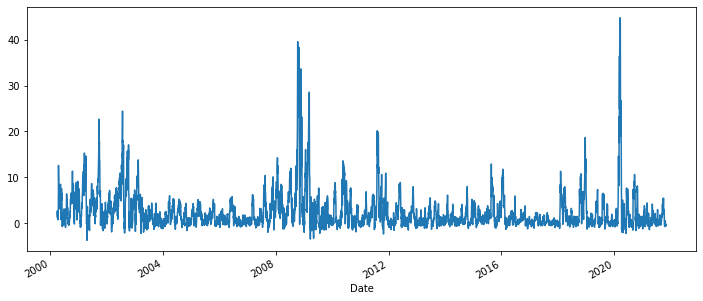

In [12]:
df['target'].plot.line(figsize=(12,5))

<AxesSubplot:>

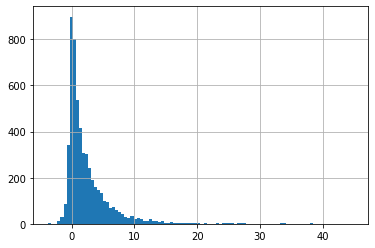

In [13]:
df['target'].hist(bins=100)

### Merlion: Anomaly detection - unsupervised with Isolation Forest 

In [14]:
train_data = TimeSeries.from_pd(df[['target']].iloc[:-200])
test_data = TimeSeries.from_pd(df[['target']].iloc[-200:])

In [15]:
# Import models & configs
from merlion.models.anomaly.isolation_forest import IsolationForest, IsolationForestConfig


# isolation forest
iso_forest_config = IsolationForestConfig()
iso_forest_model  = IsolationForest(iso_forest_config)

In [28]:
iso_forest_train_score = iso_forest_model.train(train_data=train_data, anomaly_labels=None)

<AxesSubplot:>

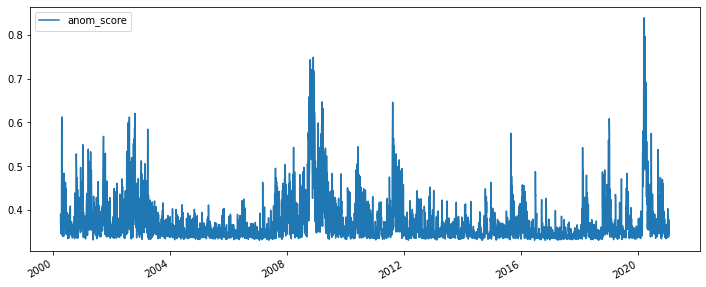

In [30]:
iso_forest_train_score.to_pd().plot.line(figsize=(12,5))

- Model Inference
   - model.get_anomaly_score() returns the model's raw anomaly scores,  
   - model.get_anomaly_label() returns the model's post-processed anomaly scores. The post-processing calibrates the anomaly scores to be interpretable as z-scores, and it also sparsifies them such that any nonzero values should be treated as an alert that a particular timestamp is anomalous.

In [32]:
test_scores = iso_forest_model.get_anomaly_score(test_data)
test_scores_df = test_scores.to_pd()

test_labels = iso_forest_model.get_anomaly_label(test_data)
test_labels_df = test_labels.to_pd()

<AxesSubplot:>

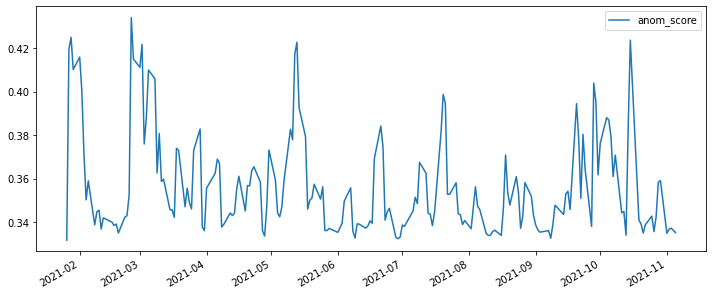

In [34]:
test_scores_df.plot.line(figsize=(12,5))

In [37]:
test_labels_df.value_counts()

anom_score
0.0           199
dtype: int64